# StateFarm Code Screen 

> Now running MLs

## 1. Import basic libraries

In [1]:
# Basic Libraries 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc


pd.set_option('display.max_rows', 500)
pd.options.mode.chained_assignment = None
#pd.set_option("display.precision", 10)

# plot settings
plt.rc('font', family='serif') 
plt.rc('font', serif='Times New Roman') 
plt.rcParams.update({'font.size': 16})
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
# Basic PySpark Libraries

# Old Style : SparkContext 
#from pyspark import SparkContext   
#from pyspark.sql import SQLContext


# New Style : Spark Session  
#Shell-Mode: Spark Session Name is `spark`

sc = spark.sparkContext
sqlsc = SQLContext(sc)
sc.setCheckpointDir("hdfs://master:54310/tmp/spark/checkpoints")

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W

In [3]:
# Enable Arrow for boosting up python performances 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## 2. Read and check `mldata` 

In [4]:
import pyarrow as pa
import pyarrow.parquet as pq

In [5]:
mldata = sqlsc.read.parquet("hdfs://master:54310/data/spark/statefarm/mldata.parquet.snappy")

In [6]:
mldata.cache()

DataFrame[x0: double, x1: double, x2: double, x3: double, x4: double, x5: double, x6: double, x7: double, x8: double, x9: double, x10: double, x11: double, x12: double, x13: double, x14: double, x15: double, x16: double, x17: double, x18: double, x19: double, x20: double, x21: double, x22: double, x23: double, x24: double, x25: double, x26: double, x27: double, x28: double, x29: double, x30: double, x31: double, x32: double, x33: double, x36: double, x37: double, x38: double, x39: double, x40: double, x42: double, x43: double, x44: double, x46: double, x47: double, x48: double, x49: double, x50: double, x51: double, x52: double, x53: double, x54: double, x55: double, x56: double, x57: double, x58: double, x59: double, x60: double, x61: double, x62: double, x63: double, x64: double, x65: double, x66: double, x67: double, x69: double, x70: double, x71: double, x72: double, x73: double, x74: double, x75: double, x76: double, x77: double, x78: double, x79: double, x80: double, x81: double,

In [7]:
mldata.count()

40000

## 3. Run MLs 

### 3.1 Trying `LightGBM` from mmlspark

> Website : https://github.com/Azure/mmlspark/blob/master/docs/lightgbm.md

In [8]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

In [9]:
from mmlspark import LightGBMClassifier

In [10]:
gbclassifier = LightGBMClassifier(learningRate=0.3, numIterations=100,\
                                  #earlyStoppingRound=10,\
                                  labelCol='y',featuresCol='features')

In [11]:
paramGrid = ParamGridBuilder().addGrid(gbclassifier.numLeaves, [10, 30, 60]).build()
gbeval = BCE(labelCol='y',metricName='areaUnderROC')

In [12]:
gbcrossval = CrossValidator(estimator=gbclassifier, estimatorParamMaps=paramGrid,\
                            evaluator=gbeval,numFolds=4)

#### Fit 

In [13]:
%%time
gbcvmodel  = gbcrossval.fit(mldata)

CPU times: user 3.21 s, sys: 1.06 s, total: 4.28 s
Wall time: 57min 20s


In [14]:
print "AUCs = ",gbcvmodel.avgMetrics

AUCs =  [0.9783873681421668, 0.9857150356912827, 0.9875472375975677]


> Okey, the `LightGBM` worked too good. This could be an **overfit**, or the **magic** of LightGBM.

In [51]:
gbcvmodel.write().overwrite().save("hdfs://master:54310/data/spark/statefarm/gbcvmodel.mlmodel")

### 3.2 Trying `RandomForestClassifier` from SparkML

In [120]:
from pyspark.ml.classification import RandomForestClassifier

In [121]:
rfclassifier = RandomForestClassifier(labelCol='y',featuresCol='features')

In [122]:
rfparamGrid = ParamGridBuilder()\
                .addGrid(rfclassifier.maxDepth, [10, 30])\
                .addGrid(rfclassifier.maxBins, [20, 60])\
                .addGrid(rfclassifier.numTrees, [20, 40, 60])\
                .build()

In [123]:
rfeval = BCE(labelCol='y',metricName='areaUnderROC')

In [124]:
rfcrossval = CrossValidator(estimator=rfclassifier, estimatorParamMaps=rfparamGrid,\
                            evaluator=rfeval,numFolds=4)

#### Fit

In [125]:
%%time
rfcvmodel  = rfcrossval.fit(mldata)

CPU times: user 5.59 s, sys: 2.88 s, total: 8.47 s
Wall time: 26min 42s


In [126]:
rfcvmodel.avgMetrics

[0.9452913506888452,
 0.95912165677448,
 0.9649417647790889,
 0.9389402510177853,
 0.9613648622919817,
 0.9692202040722852,
 0.9440974523469843,
 0.9586397951645471,
 0.9655997963702294,
 0.9389799662233435,
 0.9618717604944418,
 0.9694437431114271]

In [127]:
rfcvmodel.write().overwrite().save("hdfs://master:54310/data/spark/statefarm/rfcvmodel.mlmodel")

### 3.3 Feature Importance

In [128]:
# Covert the Vector-assembled feature importances to human-readables 
def ExtractFeatureImportance(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

#### Random Forest

In [129]:
rfFeatureImportance = ExtractFeatureImportance(rfcvmodel.bestModel.featureImportances,mldata,'features')

In [130]:
rfFeatureImportance.head(10)

,idx,name,score
107,70,x75,0.038254
72,35,x37,0.029113
128,91,x97,0.027363
91,54,x58,0.026898
131,94,x41n,0.022157
38,1,x1,0.019956
130,93,x99,0.018365
99,62,x66,0.016562
83,46,x50,0.015782
84,47,x51,0.015781


#### Displaying Top 40 Important Features

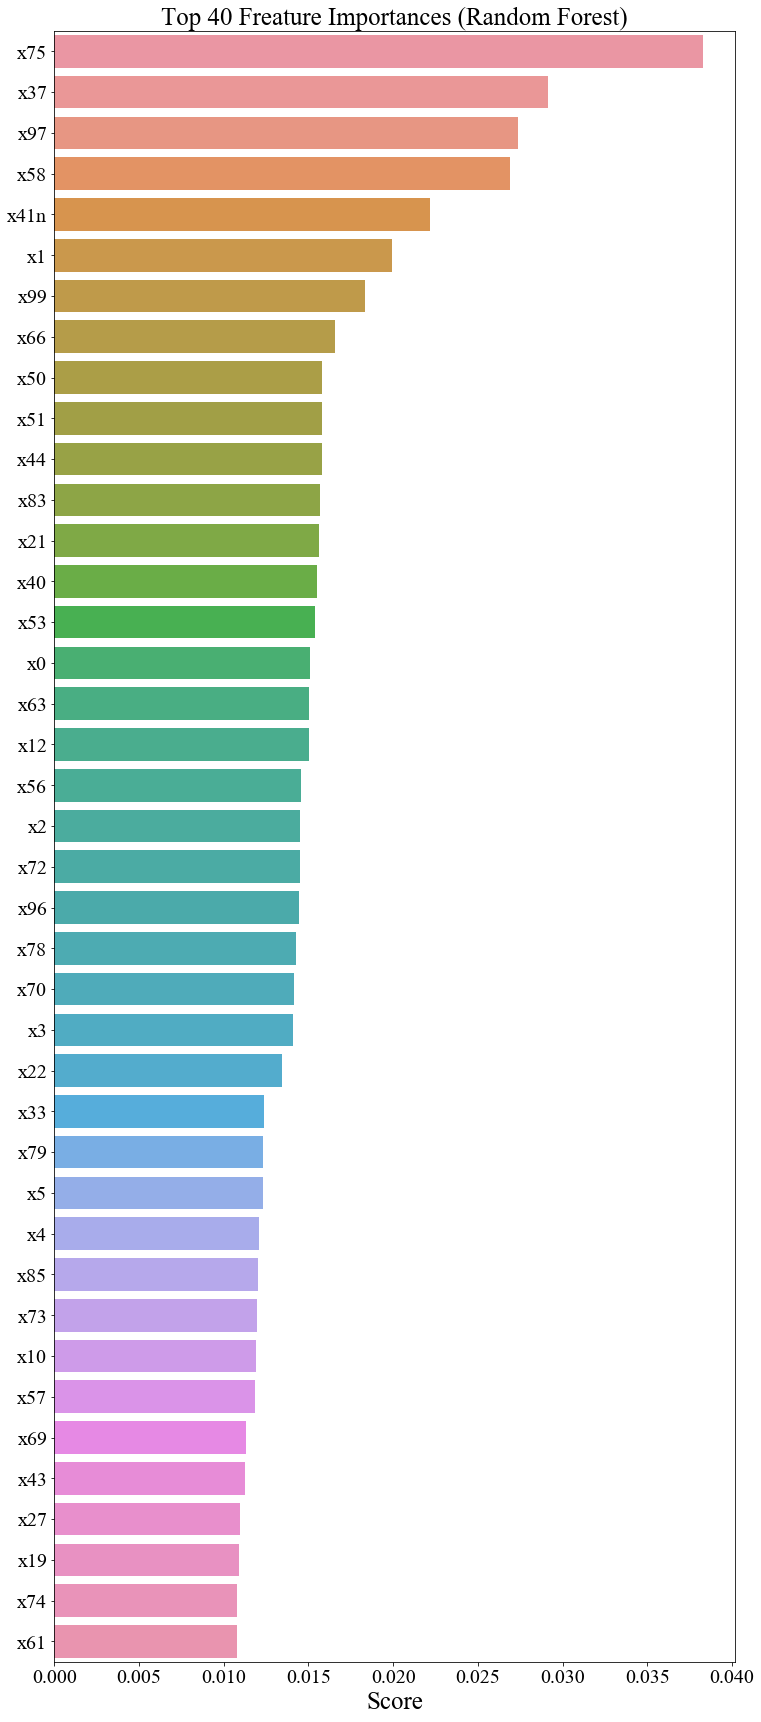

In [131]:
import seaborn as sbn
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12.2,30))

bar = sbn.barplot(x='score',y='name',data=rfFeatureImportance[:40])
bar.axes.set_title("Top 40 Freature Importances (Random Forest)",fontsize=25)
bar.set_xlabel("Score",fontsize=25)
bar.set_ylabel("",fontsize=25)
bar.tick_params(labelsize=20)

#plt.tight_layout()
plt.savefig('rfFeatures.png')
plt.savefig('rfFeatures.pdf')

plt.show()

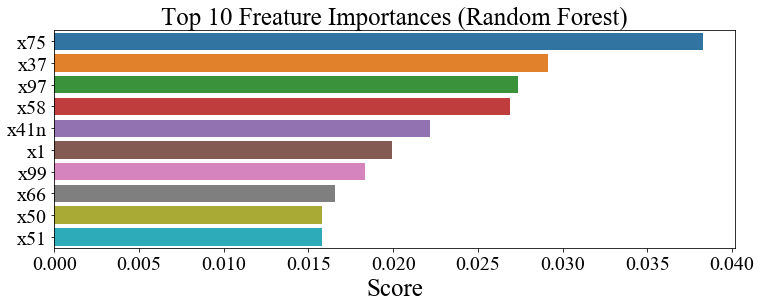

In [140]:
import seaborn as sbn
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12.2,4))

bar = sbn.barplot(x='score',y='name',data=rfFeatureImportance[:10])
bar.axes.set_title("Top 10 Freature Importances (Random Forest)",fontsize=25)
bar.set_xlabel("Score",fontsize=25)
bar.set_ylabel("",fontsize=25)
bar.tick_params(labelsize=20)

#plt.tight_layout()
plt.savefig('rfFeaturesTop10.png')
plt.savefig('rfFeaturesTop10.pdf')

plt.show()

#### Confusion Matrix

#### `RandomForestClassifier`

In [132]:
predictrf = rfcvmodel.bestModel.transform(mldata.select('features'))

In [133]:
mldata.select('features','y')\
      .join(predictrf.select('features','probability','prediction'),mldata.features==predictrf.features)\
      .show(5)

+--------------------+---+--------------------+--------------------+----------+
|            features|  y|            features|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[64.0295669054785...|  0|[64.0295669054785...|         [0.95,0.05]|       0.0|
|[69.2776483129675...|  0|[69.2776483129675...|[0.96666666666666...|       0.0|
|[-44.850336171895...|  0|[-44.850336171895...|[0.96666666666666...|       0.0|
|[34.3506047407032...|  0|[34.3506047407032...|[0.93333333333333...|       0.0|
|[-19.594669949303...|  0|[-19.594669949303...|         [0.95,0.05]|       0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 5 rows



In [134]:
resultrf = \
mldata.select('features','y')\
      .join(predictrf.select('features','probability','prediction'),mldata.features==predictrf.features)

In [135]:
resultrf.cache()

DataFrame[features: vector, y: bigint, features: vector, probability: vector, prediction: double]

In [136]:
resultrf.crosstab('y','prediction').show()

+------------+-----+----+
|y_prediction|  0.0| 1.0|
+------------+-----+----+
|           1|    2|8045|
|           0|31953|   0|
+------------+-----+----+



In [149]:
from pyspark.sql.functions import udf
secondelement=udf(lambda v:float(v[1]),T.FloatType())

In [154]:
resultrf.select(secondelement('probability').alias('probone'),'prediction').show(20)

+-----------+----------+
|    probone|prediction|
+-----------+----------+
|       0.05|       0.0|
|0.033333335|       0.0|
|0.033333335|       0.0|
| 0.06666667|       0.0|
|       0.05|       0.0|
| 0.11666667|       0.0|
|0.083333336|       0.0|
|0.016666668|       0.0|
|       0.05|       0.0|
| 0.11666667|       0.0|
|       0.05|       0.0|
|       0.05|       0.0|
|0.033333335|       0.0|
|        0.0|       0.0|
|0.016666668|       0.0|
|0.016666668|       0.0|
|       0.05|       0.0|
|  0.9166667|       1.0|
|  0.8333333|       1.0|
|       0.05|       0.0|
+-----------+----------+
only showing top 20 rows



#### `LightGBM`

In [87]:
predictgb = gbcvmodel.bestModel.transform(mldata.select('features'))

In [88]:
predictgb.columns

['features', 'rawPrediction', 'probability', 'prediction']

In [89]:
predictgb.show(5)

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[64.0295669054785...|[6.31586349191990...|[0.99819585640958...|       0.0|
|[69.2776483129675...|[7.27510038398809...|[0.99930790872784...|       0.0|
|[-44.850336171895...|[9.13124180182289...|[0.99989178061266...|       0.0|
|[34.3506047407032...|[4.94241272249465...|[0.99291322373361...|       0.0|
|[-19.594669949303...|[9.13287335144853...|[0.99989195701494...|       0.0|
+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [90]:
mldata.select('features','y')\
      .join(predictgb.select('features','probability','prediction'),mldata.features==predictgb.features)\
      .show(5)

+--------------------+---+--------------------+--------------------+----------+
|            features|  y|            features|         probability|prediction|
+--------------------+---+--------------------+--------------------+----------+
|[64.0295669054785...|  0|[64.0295669054785...|[0.99819585640958...|       0.0|
|[69.2776483129675...|  0|[69.2776483129675...|[0.99930790872784...|       0.0|
|[-44.850336171895...|  0|[-44.850336171895...|[0.99989178061266...|       0.0|
|[34.3506047407032...|  0|[34.3506047407032...|[0.99291322373361...|       0.0|
|[-19.594669949303...|  0|[-19.594669949303...|[0.99989195701494...|       0.0|
+--------------------+---+--------------------+--------------------+----------+
only showing top 5 rows



In [91]:
resultgb = \
mldata.select('features','y')\
      .join(predictgb.select('features','probability','prediction'),mldata.features==predictgb.features)

In [92]:
resultgb.cache()

DataFrame[features: vector, y: bigint, features: vector, probability: vector, prediction: double]

In [93]:
resultgb.crosstab('y','prediction').show()

+------------+-----+----+
|y_prediction|  0.0| 1.0|
+------------+-----+----+
|           1|    0|8047|
|           0|31953|   0|
+------------+-----+----+



In [155]:
resultgb.select(secondelement('probability').alias('probone'),'prediction').show(20)

+-------------+----------+
|      probone|prediction|
+-------------+----------+
| 0.0018041435|       0.0|
|  6.920913E-4|       0.0|
|1.08219385E-4|       0.0|
|  0.007086776|       0.0|
| 1.0804299E-4|       0.0|
|  0.018022794|       0.0|
| 3.6087097E-4|       0.0|
| 1.9688957E-4|       0.0|
| 2.0152802E-4|       0.0|
| 0.0017670522|       0.0|
| 3.8166858E-5|       0.0|
|  8.344073E-4|       0.0|
| 5.4461845E-5|       0.0|
| 2.2280998E-5|       0.0|
|  3.911343E-5|       0.0|
|  8.960894E-6|       0.0|
| 3.3094442E-5|       0.0|
|   0.99951065|       1.0|
|   0.99856573|       1.0|
|  0.002985313|       0.0|
+-------------+----------+
only showing top 20 rows



#### Plot the confusion matrices though they are trivial

In [156]:
gbmresult = pd.DataFrame([[31953,0],[0,8047]],columns=['0','1'])
rfresult = pd.DataFrame([[31953,0],[2,8045]],columns=['0','1'])

In [157]:
gbmNorm = gbmresult.apply(lambda row: row/np.sum(row), axis=1)
rfNorm = rfresult.apply(lambda row: row/np.sum(row), axis=1)

In [158]:
gbmNorm

,0,1
0,1.0,0.0
1,0.0,1.0


In [159]:
rfNorm

,0,1
0,1.000000,0.000000
1,0.000249,0.999751


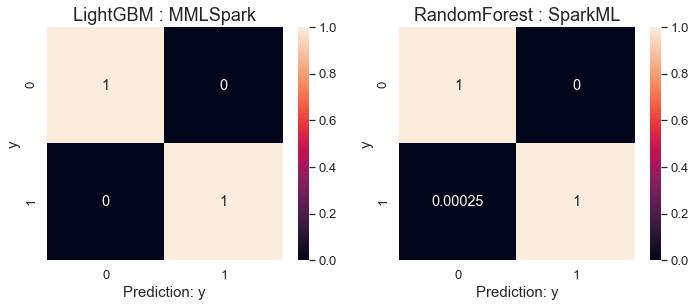

In [161]:
fig = plt.figure(figsize=(10,4.5))


sbn.set(font_scale=1.2)

plt.subplot(121)
hm = sbn.heatmap(gbmNorm, annot=True)
hm.axes.set_title("LightGBM : MMLSpark",fontsize=18)
hm.set_xlabel('Prediction: y',fontsize=15)
hm.set_ylabel('y',fontsize=15)



plt.subplot(122)
hm = sbn.heatmap(rfNorm, annot=True)
hm.axes.set_title("RandomForest : SparkML",fontsize=18)
hm.set_xlabel('Prediction: y',fontsize=15)
hm.set_ylabel('y',fontsize=15)



#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.tight_layout()
plt.savefig('result_ms.png')
plt.savefig('result_ms.pdf')

plt.show()

## 4. Predictions

### 4.1 Read the test sample

In [162]:
mldata_test = sqlsc.read.parquet("hdfs://master:54310/data/spark/statefarm/mldata_test.parquet.snappy")

In [163]:
mldata_test.count()

10000

In [165]:
predictgb_test = gbcvmodel.bestModel.transform(mldata_test.select('features'))

In [166]:
predictrf_test = rfcvmodel.bestModel.transform(mldata_test.select('features'))

In [167]:
resultgb_test = \
mldata_test.select('features')\
      .join(predictgb_test.select('features','probability','prediction'),mldata_test.features==predictgb_test.features)

In [168]:
resultrf_test = \
mldata_test.select('features')\
      .join(predictrf_test.select('features','probability','prediction'),mldata_test.features==predictrf_test.features)

In [169]:
resultgb_test.select('probability','prediction').show(10)

+--------------------+----------+
|         probability|prediction|
+--------------------+----------+
|[0.99986303652825...|       0.0|
|[0.28706831254906...|       1.0|
|[0.99867543630114...|       0.0|
|[0.99735470784743...|       0.0|
|[0.01180236982472...|       1.0|
|[0.99965308887030...|       0.0|
|[0.99998937129579...|       0.0|
|[0.98410135088640...|       0.0|
|[0.99958451875293...|       0.0|
|[0.98198174331586...|       0.0|
+--------------------+----------+
only showing top 10 rows



In [171]:
resultrf_test.select('probability','prediction').show(10)

+--------------------+----------+
|         probability|prediction|
+--------------------+----------+
|         [0.85,0.15]|       0.0|
|[0.66666666666666...|       0.0|
|[0.93333333333333...|       0.0|
|[0.73333333333333...|       0.0|
|[0.48333333333333...|       1.0|
|[0.86666666666666...|       0.0|
|           [0.9,0.1]|       0.0|
|[0.83333333333333...|       0.0|
|[0.88333333333333...|       0.0|
|[0.86666666666666...|       0.0|
+--------------------+----------+
only showing top 10 rows



In [172]:
resultgb_test.select(secondelement('probability').alias('probone')).show(10)

+------------+
|     probone|
+------------+
|1.3696347E-4|
|   0.7129317|
|0.0013245638|
| 0.002645292|
|   0.9881976|
|3.4691114E-4|
|1.0628704E-5|
| 0.015898649|
|4.1548125E-4|
| 0.018018257|
+------------+
only showing top 10 rows



In [173]:
resultrf_test.select(secondelement('probability').alias('probone')).show(10)

+----------+
|   probone|
+----------+
|      0.15|
|0.33333334|
|0.06666667|
|0.26666668|
|0.51666665|
|0.13333334|
|       0.1|
|0.16666667|
|0.11666667|
|0.13333334|
+----------+
only showing top 10 rows



#### writing the predictions to `csv`

In [177]:
resultgb_test.select(secondelement('probability').alias('probone'))\
             .toPandas().to_csv('result1.csv',index=False,header=False)

In [178]:
resultrf_test.select(secondelement('probability').alias('probone'))\
             .toPandas().to_csv('result2.csv',index=False,header=False)